# Library

In [1]:
import math
import random
import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
%matplotlib inline
print('Loaded 1')


exec(open('library.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 5000 #100*K                                      # Number of runs to do (default 10*K)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)


years = range(CURRENT_YEAR, MAX_YEAR)
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.1

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.05 + 1.15 * (year/45), 0.75)
    else:
        p = min(0.05 + 1.5 * (year/45), 0.85)
    if war:
        p = p * 0.7
    if verbose == 2:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.65

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.15

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.4

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


# TODO: Refactor
def tai_scenarios_module(y, state, verbose):
    if state['tai_type'] != 'abandoned' and state['tai_type'] != 'tool' and state['tai']:
        # TODO: Slow vs. fast takeoff
        # TODO: May not deploy TAI as soon as it is deployable
        if (sq.event_occurs(p_make_agent_tai) or state['tai_type'] == 'agent') and state['tai_type'] != 'tool':
            # TODO: Do we want to re-roll the possibility of making agentic TAI in future years?
            if sq.event_occurs(p_tai_intentional_misuse(state['war'])):
                # TODO: Parameterize the 0.5
                # TODO: May depend on who the war is between?
                if 0.5 * sq.event_occurs(p_alignment_solved(state['war'], y - CURRENT_YEAR, first_attempt=not state['tai'], verbose=verbose)):
                    if verbose:
                        # TODO: aligned by default? subtle misalignment?
                        # TODO: announce intentional misuse
                        print('{}: ...Achieved aligned TAI (aligned via work, {} attempt), happy future! :D'.format(y, '2nd+' if state['tai'] else 'first'))
                    state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
                elif sq.event_occurs(p_full_tai_misalignment_averted):
                    state['averted_misalignment'] = True
                    if sq.event_occurs(p_tai_misalignment_averting_is_catastrophic):
                        # TODO: Right now this guarantees abandonment if catastrophe - revise?
                        if verbose:
                            print('{}: ...Intentional misuse of TAI happened, was averted with catastrophe, and we abandon TAI'.format(y))
                        state['tai'] = True; state['tai_type'] = 'abandoned'
                        state['catastrophe'].append('averting_intentional_tai')
                        # TODO: Maybe resume TAI with lower chance of happening?
                    elif sq.event_occurs(p_full_tai_misalignment_averted_means_abandoned_tai):
                        if verbose:
                            print('{}: ...Intentional misuse of TAI happened, it was averted with no catastrophe, and we abandon TAI'.format(y))
                        state['tai'] = True; state['tai_type'] = 'abandoned'    
                        # TODO: Maybe resume TAI with lower chance of happening?
                    elif verbose:
                        print('{}: ...Intentional misuse of TAI happened, but it was averted'.format(y))
                else:
                    if verbose:
                        print('{}: ...XRISK from intentional misuse of TAI (singleton) :('.format(y))
                    state['category'] = 'xrisk_tai_misuse'; state['tai'] = True; state['tai_type'] = 'agent'
                    if sq.event_occurs(p_tai_singleton_is_catastrophic):
                        if verbose:
                            print('...Singleton is catastrophic')
                        state['catastrophe'].append(state['category'])
                    state['terminate'] = True; state['final_year'] = y
            elif sq.event_occurs(p_alignment_solved(state['war'], y - CURRENT_YEAR, first_attempt=not state['tai'], verbose=verbose)):
                if sq.event_occurs(p_subtle_alignment_solved):
                    if verbose:
                        print('{}: ...Achieved aligned TAI (aligned via work, {} attempt), happy future! :D'.format(y, '2nd+' if state['tai'] else 'first'))
                    state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
                else:
                    if verbose:
                        print('{}: ...XRISK from subtly unaligned TAI :('.format(y))
                    state['category'] = 'xrisk_subtly_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
            elif sq.event_occurs(p_tai_aligned_by_default):
                if sq.event_occurs(p_subtle_alignment_solved_if_aligned_by_default):
                    if verbose:
                        print('{}: ...Achieved aligned TAI (aligned by default), happy future! :D'.format(y))
                    state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
                    # TODO: Does aligned TAI make all other xrisks impossible? We currently assume it does
                        # TODO: Maybe introduce takeoff delay before other xrisks become impossible?
                else:
                    if verbose:
                        print('{}: ...XRISK from subtly unaligned TAI :('.format(y))
                    state['category'] = 'xrisk_subtly_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
            elif sq.event_occurs(p_full_tai_misalignment_averted):
                state['averted_misalignment'] = True
                if sq.event_occurs(p_tai_misalignment_averting_is_catastrophic):
                    # TODO: Right now this guarantees abandonment if catastrophe - revise?
                    if verbose:
                        print('{}: ...Misaligned TAI happened, it was averted with catastrophe, and we abandon TAI'.format(y))
                    state['tai'] = True; state['tai_type'] = 'abandoned'
                    state['catastrophe'].append('averting_misaligned_tai')
                    # TODO: Maybe resume TAI with lower chance of happening?
                elif sq.event_occurs(p_full_tai_misalignment_averted_means_abandoned_tai):
                    if verbose:
                        print('{}: ...Misaligned TAI happened, it was averted with no catastrophe, and we abandon TAI'.format(y))
                    state['tai'] = True; state['tai_type'] = 'abandoned'    
                    # TODO: Maybe resume TAI with lower chance of happening?
                elif verbose:
                    print('{}: ...Misaligned TAI happened, but it was averted'.format(y))
                    state['tai'] = True; state['tai_type'] = 'agent'
            elif sq.event_occurs(p_tai_xrisk_is_extinction):
                if verbose:
                    print('{}: ...XRISK from fully unaligned TAI (extinction) :('.format(y))
                state['category'] = 'xrisk_full_unaligned_tai_extinction'; state['tai'] = True; state['tai_type'] = 'agent'
                state['catastrophe'].append(state['category'])
                state['terminate'] = True; state['final_year'] = y
            else:
                if verbose:
                    print('{}: ...XRISK from fully unaligned TAI (singleton) :('.format(y))
                state['category'] = 'xrisk_full_unaligned_tai_singleton'; state['tai'] = True; state['tai_type'] = 'agent'
                if sq.event_occurs(p_tai_singleton_is_catastrophic):
                    if verbose:
                        print('...Singleton is catastrophic')
                    state['catastrophe'].append(state['category'])
                state['terminate'] = True; state['final_year'] = y
        else: # tool TAI
            if verbose:
                print('{}: ...Tool TAI made'.format(y))
            state['tai'] = True; state['tai_type'] = 'tool'
            # TODO: Does tool AI help mitigate xrisk?
    return state
            
    # TODO: TAI or nearness to TAI creates great power war
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Nuclear Scenarios Module

In [4]:
def p_russia_uses_nuke(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return 0.05 / 2
    else:
        return 0.001 / peace

    
p_nk_uses_nuke = 0.001

    
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0005 / peace


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.4
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
p_xrisk_from_nuclear_catastrophe = 0.07 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02


def nuclear_scenarios_module(y, state, verbose):
    peace = y < state['peace_until'] if state['peace_until'] is not None else False
    if sq.event_occurs(p_nuclear_accident(state['war'], y - CURRENT_YEAR)):
        if sq.event(p_nuclear_accident_becomes_exchange(state['war'])):
            state['nuclear_weapon_used'] = True
            if sq.event_occurs(p_catastrophe_from_nuclear_exchange(state['war'])):
                if sq.event_occurs(p_xrisk_from_nuclear_catastrophe):
                    if verbose:
                        print('{}: ...XRISK from nukes (accidental exchange) :('.format(y))
                    state['category'] = 'xrisk_nukes_accident'
                    state['terminate'] = True; state['final_year'] = y
                else:    
                    if verbose:
                        print('{}: ...catastrophe from nukes (accidental exchange)'.format(y))
                    state['catastrophe'].append('nukes_accident')
    
    first_year_of_war = state['war'] and (state['war_start_year'] == y)
    if not state['terminate'] and state['war'] and sq.event_occurs(p_nuclear_exchange_given_war(first_year_of_war)):
        state['nuclear_weapon_used'] = True
        if sq.event_occurs(p_catastrophe_from_nuclear_exchange(state['war'])):
            if sq.event_occurs(p_xrisk_from_nuclear_catastrophe):
                if verbose:
                    print('{}: ...XRISK from nukes (war) :('.format(y))
                state['category'] = 'xrisk_nukes_war'
                state['terminate'] = True; state['final_year'] = y
            else:    
                if verbose:
                    print('{}: ...catastrophe from nukes (war)'.format(y))
                state['catastrophe'].append('nukes_war')
    
    if not state['terminate'] and not state['war'] and sq.event(p_russia_uses_nuke(peace, y - CURRENT_YEAR)):
        if verbose:
            print('{}: Russia uses a nuke first strike (outside of great power war)!'.format(y))
        state['nuclear_weapon_used'] = True
        state['russia_nuke_first'] = True
        
    if not state['terminate'] and sq.event(p_nk_uses_nuke):
        if verbose:
            print('{}: North Korea uses a nuke first strike!'.format(y))
        state['nuclear_weapon_used'] = True
    
    if not state['terminate'] and not state['war'] and sq.event(p_other_uses_nuke(peace)):
        if verbose:
            print('{}: A country other than Russia uses a nuke first strike (outside of great power war)!'.format(y))
        state['nuclear_weapon_used'] = True

                
    return state

print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [5]:
def p_great_power_war_us_russia_without_nuke_first(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return (0.02 / 2) / peace
    else:
        return 0.003 / peace

    
def p_great_power_war_us_china(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year >= 2040:
        return 0.005 / peace
    else:
        if year < 2025:
            p_invade_taiwan = 0.1 / 5
        elif year < 2030:
            p_invade_taiwan = (0.3 / 5) * (1 - 0.1)
        elif year < 2040:
            p_invade_taiwan = (0.7 / 10) * (1 - 0.3) * (1 - 0.1)
        p_us_responds = 0.6
        return (p_invade_taiwan * p_us_responds) / peace

    
def p_great_power_war_other(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year > 2040:
        return 0.005 / peace
    else:
        return 0.001 / peace


# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
peace_length = sq.lognorm(10, 100)

# TODO: There should be a small chance of catastrophe and x-risk from great power war, absent nuclear or bio pathway
# TODO: There should be a chance of nukes-related catastrophe and x-risk from breaking nuclear symmetry


def great_power_war_scenarios_module(y, state, verbose):
    peace = y < state['peace_until'] if state['peace_until'] is not None else False
    
    if not state['war'] and (sq.event_occurs(p_great_power_war_us_russia_without_nuke_first(peace, y - CURRENT_YEAR)) or
                             state['russia_nuke_first']):
        if verbose:
            print('{}: WAR!!! (US vs. Russia)'.format(y))
        state['war'] = True
        state['war_start_year'] = y
        war_length_ = int(round(sq.sample(war_length)))
        state['war_end_year'] = war_length_ + y
        state['war_belligerents'] = 'US/Russia'
        state['wars'].append({'belligerents': state['war_belligerents'],
                              'start_year': state['war_start_year'],
                              'end_year': state['war_end_year'],
                              'war_length': war_length_})
        state['russia_nuke_first'] = False
        
    elif sq.event_occurs(p_great_power_war_us_china(peace, y - CURRENT_YEAR)) and not state['war']:
        if verbose:
            print('{}: WAR!!! (US vs. China)'.format(y))
        state['war'] = True
        state['war_start_year'] = y
        war_length_ = int(round(sq.sample(war_length)))
        state['war_end_year'] = war_length_ + y
        state['war_belligerents'] = 'US/China'
        state['wars'].append({'belligerents': state['war_belligerents'],
                              'start_year': state['war_start_year'],
                              'end_year': state['war_end_year'],
                              'war_length': war_length_})
    
    elif sq.event_occurs(p_great_power_war_other(peace, y - CURRENT_YEAR)) and not state['war']:
        if verbose:
            print('{}: WAR!!! (Other)'.format(y))
        state['war'] = True
        state['war_start_year'] = y
        war_length_ = int(round(sq.sample(war_length)))
        state['war_end_year'] = war_length_ + y
        state['war_belligerents'] = 'Other'
        state['wars'].append({'belligerents': state['war_belligerents'],
                              'start_year': state['war_start_year'],
                              'end_year': state['war_end_year'],
                              'war_length': war_length_})
        
    elif state['war'] and (y >= state['war_end_year'] or state['category'] == 'aligned_tai'):
        if verbose:
            print('{}: War ends :)'.format(y))
        state['war'] = False
        state['war_belligerents'] = None
        peace_length_ = int(round(sq.sample(peace_length)))
        state['peace_until'] = y + peace_length_
        
    return state

print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [6]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1200

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_90_pct_death = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            increase_from_globalization *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


def bio_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_natural_bio(y - CURRENT_YEAR)):
        state['natural_pathogen'] = True
        if sq.event_occurs(p_natural_bio_is_catastrophe):
            if sq.event_occurs(p_xrisk_from_accidental_bio_given_catastrophe(y - CURRENT_YEAR)):
                if verbose:
                    print('{}: ...XRISK from pathogen (lab-leak) :('.format(y))
                state['category'] = 'xrisk_bio_accident'
                state['terminate'] = True; state['final_year'] = y
                state['catastrophe'].append('natural_pathogen')
            else:
                if verbose:
                    print('{}: ...catastrophe from natural pathogen'.format(y))
                state['catastrophe'].append('natural_pathogen')

    if not state['terminate'] and sq.event_occurs(p_accidental_bio(state['war'])):
        engineered = sq.event_occurs(ratio_engineered_vs_natural_lab_leak)
        if engineered:
            state['engineered_pathogen'] = True
        else:
            state['natural_pathogen'] = True
        if sq.event_occurs(p_engineered_bio_is_catastrophe):
            if sq.event_occurs(p_xrisk_from_accidental_bio_given_catastrophe(y - CURRENT_YEAR)):
                if verbose:
                    print('{}: ...XRISK from pathogen (lab-leak) :('.format(y))
                state['category'] = 'xrisk_bio_accident'
                state['terminate'] = True; state['final_year'] = y
                state['catastrophe'].append('engineered_pathogen' if engineered else 'natural_pathogen')
            else:
                if verbose:
                    if engineered:
                        print('{}: ...catastrophe from lab-leak engineered pathogen'.format(y))
                    else:
                        print('{}: ...catastrophe from lab-leak natural pathogen'.format(y))
                state['catastrophe'].append('engineered_pathogen' if engineered else 'natural_pathogen')
    
    if not state['terminate'] and state['war'] and sq.event_occurs(p_biowar_given_war):
        state['engineered_pathogen'] = True
        if sq.event_occurs(p_engineered_bio_is_catastrophe):
            if sq.event_occurs(p_xrisk_from_engineered_bio_given_catastrophe(y - CURRENT_YEAR)):
                if verbose:
                    print('{}: ...XRISK from pathogen (war) :('.format(y))
                state['category'] = 'xrisk_bio_war'
                state['terminate'] = True; state['final_year'] = y
                state['catastrophe'].append('engineered_pathogen')
            else:
                if verbose:
                    print('{}: ...catastrophe from pathogen (war)'.format(y))
                state['catastrophe'].append('engineered_pathogen')
    
    if not state['terminate'] and sq.event_occurs(p_nonstate_bio):
        engineered = sq.event_occurs(ratio_engineered_vs_natural_lab_leak)
        if engineered:
            state['engineered_pathogen'] = True
        else:
            state['natural_pathogen'] = True
        if sq.event_occurs(p_engineered_bio_is_catastrophe):
            if sq.event_occurs(p_xrisk_from_engineered_bio_given_catastrophe(y - CURRENT_YEAR)):
                if verbose:
                    print('{}: ...XRISK from pathogen (nonstate) :('.format(y))
                state['category'] = 'xrisk_bio_nonstate'
                state['terminate'] = True; state['final_year'] = y
                state['catastrophe'].append('engineered_pathogen' if engineered else 'natural_pathogen')
            else:
                if verbose:
                    if engineered:
                        print('{}: ...catastrophe from engineered pathogen'.format(y))
                    else:
                        print('{}: ...catastrophe from natural pathogen'.format(y))
                state['catastrophe'].append('engineered_pathogen' if engineered else 'natural_pathogen')
                
    return state

print('Loaded bio scenarios module')

Loaded bio scenarios module


### Nanotech scenarios module

In [7]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


def nano_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_nanotech_possible(y - CURRENT_YEAR)) and not state['nano']:
        state['nano'] = True
        if sq.event_occurs(p_nanotech_is_xrisk):
            if verbose:
                print('{}: ...XRISK from nanotech :('.format(y))
            state['category'] = 'xrisk_nanotech'
            state['catastrophe'].append(state['category'])
            state['terminate'] = True; state['final_year'] = y
        # TODO: Catastrophic but non x-risk nano?
        # TODO: catastrophe or nano x-risk but not in the first year?
                        
    return state

print('Loaded nano scenarios module')

Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [8]:
p_supervolcano_catastrophe = 1 / (30*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/

p_supervolcano_extinction = 1 / (4*M)    # https://www.nature.com/articles/s41598-019-47540-7

p_supervolcano_extinction_given_catastrophe = p_supervolcano_extinction / p_supervolcano_catastrophe


def supervolcano_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_supervolcano_catastrophe):
        if sq.event_occurs(p_supervolcano_extinction_given_catastrophe):
            if verbose:
                print('{}: ...XRISK from supervolcano'.format(y))
            state['category'] = 'xrisk_supervolcano'
            state['catastrophe'].append(state['category'])
            state['terminate'] = True; state['final_year'] = y
        else:
            if verbose:
                print('{}: ...Catastrophe from supervolcano'.format(y))
            state['catastrophe'].append('supervolcano')
            
    return state

print('Loaded supervolcano module')

Loaded supervolcano module


### Unknown unknown scenarios module

In [9]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1


p_extinction_from_double_catastrophe = 0.1
extinction_from_double_catastrophe_range = 10
    

def unknown_unknown_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_unknown_unknown_xrisk(y - CURRENT_YEAR)):
        if verbose:
            print('{}: ...XRISK from unknown unknown'.format(y))
        state['category'] = 'xrisk_unknown_unknown'
        state['catastrophe'].append(state['category'])
        # TODO: What % of "unknown unknowns" are extinction?
        # TODO: catastrophic but not x-risk unknown unknowns?
        state['terminate'] = True; state['final_year'] = y
        
    return state

print('Loaded unknown unknown scenarios module')

Loaded unknown unknown scenarios module


### AI Timeline variables

In [10]:
## AI TIMELINE VARIABLES

def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    # Debug = 1 for just printing parameters
    # Debug = 2 for just printing the equation
    # Debug = True or debug = 3 for printing both
    
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = sq.sample(brain)
    eff_ = sq.sample(efficiency)
    tvh_ = sq.sample(transformative_vs_human)
    h_ = sq.sample(horizon_length)
    e_ = sq.sample(scaling_exponent)
    fpp_ = sq.sample(flops_per_param_per_sec)
    
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('Anchor debug:')
        
    if debug is True or debug == 1 or debug == 3:
        print('-- Assume human brain in inference takes {} log FLOP'.format(round(brain_, 1)))
        print('-- Add {} log FLOP for efficiency'.format(round(eff_, 1)))
        print('-- Assume a transformative model takes {} log FLOP compared to human'.format(round(tvh_, 1)))
        print('-- Assume a horizon length of {}'.format(round(h_, 1)))
        print('-- Assume a scaling exponent of {}'.format(round(e_, 3)))
        print('-- Assume FLOPs per param per sec of {}'.format(round(fpp_, 1)))
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
    else:
        params_ = sq.sample(params)
    
    out = brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_
    
    if debug is True or debug == 2 or debug == 3:
        if params is None:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * ({round(brain_, 1)} + {round(eff_, 1)} - {round(fpp_, 1)})")
        else:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * {round(params_, 2)}")
    
    out = bayes_update(out)
    if debug is True or debug == 2 or debug == 3:
        print('-- {} after Bayes update'.format(round(out, 1)))
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('-')

    return out


def wildeford_bayes_update_against_low_flop(f):
    f = f + sq.sample(sq.norm(1,3)) if f < 27 and sq.event_occurs(p=0.1) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 26 and sq.event_occurs(p=0.2) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 25 and sq.event_occurs(p=0.6) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 24 and sq.event_occurs(p=0.8) else f
    return f


def wildeford_meta_anchor(efficiency, debug=False):
    horizon_length = sq.mixture([[0.4, sq.const(0)],
                                 [0.2, sq.norm(0,3)],
                                 [0.25, sq.lognorm(3,7)],
                                 [0.15, sq.norm(7,11)]],
                                lclip=0)
    
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=efficiency,
                                     transformative_vs_human=sq.norm(-2,1),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=wildeford_bayes_update_against_low_flop,
                                     debug=debug)


def max_gdp_frac(war):
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/500, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if (not war and r_ < 0.3) or (war and r_ < 0.05):
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.2,0.6, lclip=0.1, rclip=0.9)
    elif (not war and r_ < 0.9) or (war and r_ < 0.4):
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.4,0.7, lclip=0.1, rclip=0.9)
    elif not war or (war and r_ < 0.9):
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5,0.9, lclip=0.1, rclip=0.9)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.6,0.9, lclip=0.1, rclip=0.9)
        
    return sq.sample(gdp_frac) * sq.sample(percent_spent_on_compute)


initial_gdp = 21.3*T

initial_flops_per_dollar = sq.const(18)

tai_flop_size = wildeford_meta_anchor

flops_halving_rate = sq.lognorm(2, 5)

initial_pay = sq.mixture([[0.8, sq.const(7.1)],
                          [0.2, sq.lognorm(7.1,9, lclip=7.1)]])

max_flops_per_dollar = sq.const(24)

gdp_growth = sq.lognorm(1.015, 1.035) #NEW

spend_doubling_time = sq.mixture([[0.8, sq.lognorm(3,6)],
                                  [0.2, sq.lognorm(1,2, lclip=1)]])
# TODO: Willingness to spend connected to commercialization

initial_chance_of_nonscaling_issue = 0.95
final_chance_of_nonscaling_issue = 0.3 #NEW
nonscaling_issue_bottom_year = 2050
nonscaling_delay = sq.mixture([[0.7, sq.lognorm(2,10)],
                               [0.3, sq.lognorm(5,40)]]) #NEW

algo_doubling_rate_max = sq.norm(1,3) # NEW
algo_doubling_rate_min = sq.norm(1,2) # NEW

efficiency = sq.mixture([[0.1, sq.const(0)],
                          [0.9, sq.lognorm(1,4)]])

use_efficiency_based_algo_reduction = True
efficiency_based_additional_reduction = sq.mixture([[0.4, sq.const(0)],
                                                    [0.6, sq.norm(0,2)]]) # NEW

p_willingness_ramp = 0

willingness_spend_horizon = sq.const(1)

tai_china_war_delay_yrs = sq.norm(2,6)
tai_china_war_delay_end_year = 2040

tai_catastrophe_delay_yrs = sq.lognorm(4,20)

# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)


def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 650:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)
    

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)


def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 650:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

    
def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 650:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

    
def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)


# NEW
def p_nonscaling_delay(initial_p, final_p, year, max_year):
    return generalized_logistic_curve(x=year - CURRENT_YEAR,
                                      slope=0.3,
                                      shift=3 * (max_year - CURRENT_YEAR),
                                      push=1,
                                      maximum=final_p,
                                      minimum=initial_p)


print('Loaded')


Loaded


### Overall module structure

In [11]:
STATES = ['boring', 'xrisk_tai_misuse', 'aligned_tai', 'xrisk_full_unaligned_tai_extinction',
          'xrisk_full_unaligned_tai_singleton', 'xrisk_subtly_unaligned_tai', 'xrisk_unknown_unknown',
          'xrisk_nanotech', 'xrisk_nukes_war', 'xrisk_nukes_accident', 'xrisk_bio_accident', 'xrisk_bio_war',
          'xrisk_bio_nonstate', 'xrisk_supervolcano']

extinctions = ['xrisk_full_unaligned_tai_extinction', 'xrisk_nukes_war', 'xrisk_nukes_accident',
               'xrisk_unknown_unknown', 'xrisk_nanotech', 'xrisk_bio_accident', 'xrisk_bio_war',
               'xrisk_bio_nonstate', 'xrisk_supervolcano']


def define_event(verbose=False):
    state = {'category': 'boring', 'tai': False, 'tai_year': None, 'tai_type': None,
             'nano': False, 'wars': [], 'war': False, 'war_start_year': None, 'war_end_year': None,
             'russia_nuke_first': False, 'war_belligerents': None, 'peace_until': None,
             'engineered_pathogen': False, 'natural_pathogen': False, 'averted_misalignment': False,
             'nuclear_weapon_used': False, 'catastrophe': [], 'recent_catastrophe_year': None,
             'terminate': False, 'final_year': None, 'double_catastrophe_xrisk': None}
    allowed_state_keys = list(state.keys())
    collectors = {}
    
    ## Set up timelines calculations
    # TODO: Can timelines stuff be factored out?
    if use_efficiency_based_algo_reduction:
        efficiency_ = sq.sample(efficiency)
        tai_flop_size_ = sq.sample(lambda: tai_flop_size(efficiency=sq.const(efficiency_),
                                                         debug=verbose))
    else:
        tai_flop_size_ = sq.sample(tai_flop_size)

    if tai_flop_size_ > 300:
        tai_flop_size_ = int(tai_flop_size_) # Handle overflow errors
    
    algo_doubling_rate_ = algo_halving_fn(sq.sample(algo_doubling_rate_min),
                                          sq.sample(algo_doubling_rate_max),
                                          tai_flop_size_)
    
    if use_efficiency_based_algo_reduction:
        possible_algo_reduction_ = possible_algo_reduction_fn(efficiency_, efficiency_, tai_flop_size_)
        if efficiency_based_additional_reduction:
            possible_algo_reduction_ += sq.sample(efficiency_based_additional_reduction)
    else:
        possible_algo_reduction_ = possible_algo_reduction_fn(sq.sample(min_reduction),
                                                              sq.sample(max_reduction),
                                                              tai_flop_size_)
    
    initial_flops_per_dollar_ = 10 ** sq.sample(initial_flops_per_dollar)
    flops_halving_rate_ = sq.sample(flops_halving_rate)
    max_flops_per_dollar_ = 10 ** sq.sample(max_flops_per_dollar)
    initial_pay_ = 10 ** sq.sample(initial_pay)
    gdp_growth_ = sq.sample(gdp_growth)
    max_gdp_frac_ = max_gdp_frac(state['war'])
    
    willingness_ramp_happens = sq.event_occurs(p_willingness_ramp)
    if willingness_ramp_happens:
        willingness_ramp_ = sq.sample(willingness_ramp)
    else:
        willingness_ramp_ = 1
    
    initial_gdp_ = initial_gdp
    spend_doubling_time_ = sq.sample(spend_doubling_time)
    nonscaling_delay_ = sq.sample(nonscaling_delay)
    nonscaling_countdown = 0
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    nonscaling_issue_bottom_year_ = nonscaling_issue_bottom_year
    willingness_spend_horizon_ = int(sq.sample(willingness_spend_horizon))
    tai_china_war_delay_yrs_ = None
    tai_catastrophe_delay_yrs_ = None
    
    queue_tai_year = 99999
    plt.ioff()
    if verbose:
        cost_of_tai_collector = []
        willingness_collector = []
    
    if verbose:
        print('### TAI TIMELINE VARIABLES ###')
        print('It takes {} log FLOPs (~{}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                    numerize(10 ** tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs (~{}) per 2022$USD. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs (~{}) per 2022$USD.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                               numerize(initial_flops_per_dollar_),
                                                                               np.round(flops_halving_rate_, 1),
                                                                               np.round(math.log10(max_flops_per_dollar_), 1),
                                                                               numerize(max_flops_per_dollar_)))
        print(('We are willing to pay {} log 2022$USD (~{}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(initial_pay_),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 5),
                                                              np.round(gdp_growth_, 3)))
        if willingness_ramp_ < 1:
            print('In this simulation, if we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))

        if willingness_spend_horizon_ > 1:
            print('We are willing to spend over {} years to make TAI'.format(willingness_spend_horizon_))
            
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('-')
    
    is_nonscaling_issue = None

    for y in years:
        n_catastrophes = len(state['catastrophe'])
        
        # Run modules
        if not state['terminate']:
            state = tai_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = great_power_war_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = nuclear_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = bio_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = nano_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = supervolcano_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = unknown_unknown_scenarios_module(y, state, verbose)
        
        # Check for double-dip catastrophe -> x-risk
        # TODO: Move to module?
        catastrophe_this_year = len(state['catastrophe']) > n_catastrophes
        if not state['terminate'] and catastrophe_this_year:
            prior_catastrophe_within_range = n_catastrophes > 0 and y < (state['recent_catastrophe_year'] + extinction_from_double_catastrophe_range)
            if prior_catastrophe_within_range and sq.event(p_extinction_from_double_catastrophe):
                previous_catastrophe = state['catastrophe'][-2]
                current_catastrophe = state['catastrophe'][-1]
                if verbose:
                    print('{}: ...XRISK from double catastrophe ({} -> {})'.format(y, previous_catastrophe, current_catastrophe))
                
                if current_catastrophe == 'averting_intentional_tai' or current_catastrophe == 'averting_misaligned_tai':
                    xrisk_name = 'xrisk_full_unaligned_tai_extinction'
                elif current_catastrophe == 'natural_pathogen':
                    xrisk_name = 'xrisk_bio_accident'
                elif current_catastrophe == 'engineered_pathogen':
                    xrisk_name = 'xrisk_bio_accident'
                elif 'xrisk_' in current_catastrophe:
                    xrisk_name = current_catastrophe
                else:
                    xrisk_name = 'xrisk_{}'.format(current_catastrophe)
                state['category'] = xrisk_name
                state['double_catastrophe_xrisk'] = '{}->{}'.format(previous_catastrophe, current_catastrophe)
                state['terminate'] = True; state['final_year'] = y
            state['recent_catastrophe_year'] = y
            

        # Check if TAI is created this year
        # TODO: Move to module?
        if not state['terminate'] and not state['tai']:
            if catastrophe_this_year:
                tai_catastrophe_delay_yrs_ = int(round(sq.sample(tai_catastrophe_delay_yrs)))
                if nonscaling_countdown > 0:
                    nonscaling_countdown += tai_catastrophe_delay_yrs_
                    if verbose:
                        print('Catastrophe adds {} yrs to nonscaling delay'.format(tai_catastrophe_delay_yrs_))
                elif verbose:
                    print('Catastrophe delays TAI progress by {} years'.format(tai_catastrophe_delay_yrs_))
                
            if state['war'] and y == state['war_start_year']:
                old_max_gdp_frac_ = max_gdp_frac_
                max_gdp_frac_ = max_gdp_frac(war=True)
                if verbose:
                    print('Due to war, our willingness to pay for TAI has moved from {}% of GDP to {}% of GDP'.format(round(old_max_gdp_frac_, 5),
                                                                                                                      round(max_gdp_frac_, 5)))
                if state['war_belligerents'] == 'US/China' and y < tai_china_war_delay_end_year:
                    tai_china_war_delay_yrs_ = int(round(sq.sample(tai_china_war_delay_yrs)))
                    if nonscaling_countdown > 0:
                        nonscaling_countdown += tai_china_war_delay_yrs_
                        if verbose:
                            print('War with China adds {} yrs to nonscaling delay'.format(tai_china_war_delay_yrs_))
                    elif verbose:
                        print('Due to war with China, TAI progress is delayed {} years'.format(tai_china_war_delay_yrs_))
            
            if not state['war'] and y == state['war_end_year']:
                old_max_gdp_frac_ = max_gdp_frac_
                max_gdp_frac_ = max_gdp_frac(war=False)
                if verbose:
                    print('Due to war ending, our willingness to pay for TAI has moved from {}% of GDP to {}% of GDP'.format(round(old_max_gdp_frac_, 5),
                                                                                                                             round(max_gdp_frac_, 5)))
                
            
            
            
            
            y_relative = y - CURRENT_YEAR
            tai_catastrophe_delay_yrs__ = tai_catastrophe_delay_yrs_
            if (tai_catastrophe_delay_yrs__ and
                state['recent_catastrophe_year'] and
                y_relative - tai_catastrophe_delay_yrs__ < (state['recent_catastrophe_year'] - CURRENT_YEAR)):
                    tai_catastrophe_delay_yrs__ = y - state['recent_catastrophe_year']

            tai_china_war_delay_yrs__ = tai_china_war_delay_yrs_
            if (tai_china_war_delay_yrs__ and
                state['war_start_year'] and
                y_relative - tai_china_war_delay_yrs__ < (state['war_start_year'] - CURRENT_YEAR)):
                    tai_china_war_delay_yrs__ = y - state['war_start_year']

            y_relative = y_relative - tai_catastrophe_delay_yrs__ if tai_catastrophe_delay_yrs__ else y_relative
            y_relative = y_relative - tai_china_war_delay_yrs__ if tai_china_war_delay_yrs__ else y_relative

            if verbose == 2:
                print('- Year is {} (normal relative year is {}, adjusted relative year is {})'.format(y,
                                                                                                        y - CURRENT_YEAR,
                                                                                                        y_relative))

            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=y_relative)

            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=y_relative)

            if flops_per_dollar_ > 10 ** 200 or flops_needed_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                cost_of_tai_ = flops_needed_ // flops_per_dollar_
            else:
                cost_of_tai_ = flops_needed_ / flops_per_dollar_

            willingness_ = willingness_to_pay(initial_gdp=initial_gdp_,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=y_relative)

            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)

            if verbose:
                cost_of_tai_collector.append(cost_of_tai_)
                willingness_collector.append(willingness_)

            total_compute_ = willingness_ * flops_per_dollar_

            if verbose == 2:
                out_str = (' --- {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(np.round(math.log10(total_compute_), 1),
                                     numerize(total_compute_),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(flops_needed_),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(cost_of_tai_),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(willingness_),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(flops_per_dollar_)))
                print('-')

            if cost_of_tai_ > 10 ** 200:
                spend_tai_years = int(cost_of_tai_) // int(willingness_)
            else:
                spend_tai_years = cost_of_tai_ / willingness_

            if not is_nonscaling_issue and queue_tai_year < 99999 and verbose == 2:
                print('-$- {}/{}'.format(y, queue_tai_year))
            if (cost_of_tai_ * willingness_ramp_) <= willingness_ or y >= queue_tai_year:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue_,
                                                             final_chance_of_nonscaling_issue_,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year_)
                    is_nonscaling_issue = sq.event(p_nonscaling_delay_)
                    nonscaling_countdown = nonscaling_delay_
                    if verbose == 2:
                        print('-- {} p_nonscaling_issue={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                   np.round(p_nonscaling_delay_, 4)))

                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if verbose:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    state['tai'] = True
                    state['tai_year'] = y
                else:
                    if verbose == 2:
                        print('{}: /!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(y, np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            elif (not is_nonscaling_issue and willingness_spend_horizon_ > 1 and
                  spend_tai_years <= willingness_spend_horizon_ and y + math.ceil(spend_tai_years) < queue_tai_year):
                queue_tai_year = y + math.ceil(spend_tai_years)
                if verbose == 2:
                    print('-$- We have enough spend to make TAI in {} years (in {}) if sustained.'.format(math.ceil(spend_tai_years),
                                                                                                          queue_tai_year))


        ## Check validity of state
        for k in list(state.keys()):
            if k not in allowed_state_keys:
                raise ValueError('key {} found and not provisioned'.format(k))
        if state['category'] not in STATES:
            raise ValueError('State {} not in `STATES`'.format(state['category']))

        ## Run collectors
        collectors[y] = deepcopy(state)
                
            
    ## Boring future if MAX_YEAR is reached with no termination
    if not state['terminate']:
        if verbose:
            print('...Boring future')
        state['final_year'] = '>{}'.format(y)

    if verbose:
        print('-')
        print('-')
    
    tai_metadata = {'initial_gdp': initial_gdp_,
                    'tai_flop_size': tai_flop_size_,
                    'nonscaling_delay': nonscaling_delay_,
                    'algo_doubling_rte': algo_doubling_rate_,
                    'possible_algo_reduction': possible_algo_reduction_,
                    'initial_flops_per_dollar': initial_flops_per_dollar_,
                    'flops_halving_rate': flops_halving_rate_,
                    'max_flops_per_dollar': max_flops_per_dollar_,
                    'initial_pay': initial_pay_,
                    'gdp_growth': gdp_growth_,
                    'max_gdp_frac': max_gdp_frac_,
                    'willingness_ramp_': willingness_ramp_,
                    'spend_doubling_time_': spend_doubling_time_,
                    'initial_chance_of_nonscaling_issue': initial_chance_of_nonscaling_issue_,
                    'final_chance_of_nonscaling_issue': final_chance_of_nonscaling_issue_,
                    'nonscaling_issue_bottom_year': nonscaling_issue_bottom_year_,
                    'willingness_spend_horizon_': willingness_spend_horizon_,
                    'tai_china_war_delay_yrs': tai_china_war_delay_yrs_}
        
    return {'collectors': collectors,
            'tai_metadata': tai_metadata,
            'final_state': state}


print('Model loaded')


Model loaded


Anchor debug:
-- 30.0 = 14.7 + 0 + 0.1 + 0.4 + 12 - 1.369 * 11.2 + 1.369 * (14.7 + 0 - 1.4)
-- 30.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 30.0 log FLOPs (~967 octillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 0.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.2 log 2022$USD (~151 million) and this increases by 4.4x per year to a max of 0.00049% of GDP. GDP grows at a rate of 1.039x per year.
If a non-scaling delay happens, it will take an additional 2.0 years to produce TAI due to issues unrelated to scaling FLOP
-
- Year is 2022 (normal relative year is 0, adjusted relative year is 0)
 --- 26.2 max log FLOP (149 septillion) available - TAI takes 30.0 log FLOP (967 octillion) - log $ 12.0 to buy TAI (967 billion) vs. willingness to pay log $ 8.2 (149 mill

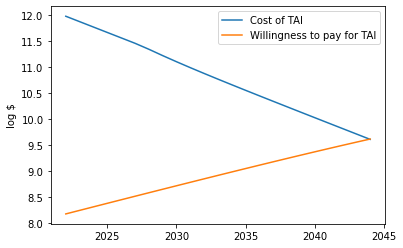

2045: ...Tool TAI made
2062: WAR!!! (US vs. China)
2071: War ends :)
2154: WAR!!! (US vs. Russia)
2157: War ends :)
2206: WAR!!! (US vs. China)
...Boring future
-
-
{'collectors': {2022: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': None,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': False,
                       'peace_until': None,
                       'recent_catastrophe_year': None,
                       'russia_nuke_first': False,
                       'tai': False,
                       'tai_type': None,
                       'tai_year': None,
                       'terminate': False,
                       'war': False,
                       'war_belligerents': None,
 

                       'war_start_year': None,
                       'wars': []},
                2046: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': None,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': False,
                       'peace_until': None,
                       'recent_catastrophe_year': None,
                       'russia_nuke_first': False,
                       'tai': True,
                       'tai_type': 'tool',
                       'tai_year': 2044,
                       'terminate': False,
                       'war': False,
                       'war_belligerents': None,
                       'war_end_year': None,
                       'war_start_yea

                       'wars': [{'belligerents': 'US/China',
                                 'end_year': 2071,
                                 'start_year': 2062,
                                 'war_length': 9},
                                {'belligerents': 'US/Russia',
                                 'end_year': 2157,
                                 'start_year': 2154,
                                 'war_length': 3}]},
                2196: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'double_catastrophe_xrisk': None,
                       'engineered_pathogen': False,
                       'final_year': None,
                       'nano': True,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': True,
                       'peace_until': 2176,
                       'recent_catastrophe_year': None,
                       'russia_n

In [12]:
pprint(define_event(verbose=2))

In [13]:
sq.get_percentiles(sq.sample(lambda: max_gdp_frac(war=True), n=1000))

{1: 2.5338506136433888e-06,
 5: 0.00012215243024220386,
 10: 0.0005172797273153353,
 20: 0.0006436015011604491,
 30: 0.0007668538029183132,
 40: 0.000994862825944322,
 50: 0.0016722114275481734,
 60: 0.002103984454770348,
 70: 0.002642555260790936,
 80: 0.0034338015937779307,
 90: 0.005204390974528666,
 95: 0.008577914095104175,
 99: 0.014336529701828023}

In [14]:
sq.get_percentiles(sq.sample(lambda: max_gdp_frac(war=False), n=1000))

{1: 9.589791852152864e-07,
 5: 3.4455224865435316e-06,
 10: 6.466052937632967e-06,
 20: 2.119041338910027e-05,
 30: 0.0002020032713250438,
 40: 0.0005497624996068229,
 50: 0.0006164042728410903,
 60: 0.0006827040126153822,
 70: 0.0007436020119362334,
 80: 0.0008421044405472686,
 90: 0.0011450499566687208,
 95: 0.0025622306501226037,
 99: 0.004068893006263945}

In [15]:
sq.get_percentiles(sq.sample(lambda: int(round(sq.sample(tai_china_war_delay_yrs))), n=1000))

{1: 1.0,
 5: 2.0,
 10: 2.0,
 20: 3.0,
 30: 3.0,
 40: 4.0,
 50: 4.0,
 60: 4.0,
 70: 5.0,
 80: 5.0,
 90: 6.0,
 95: 6.0,
 99: 7.0}

In [16]:
sq.get_percentiles(sq.sample(lambda: int(round(sq.sample(tai_catastrophe_delay_yrs))), n=1000))

{1: 3.0,
 5: 4.0,
 10: 5.0,
 20: 6.0,
 30: 7.0,
 40: 8.0,
 50: 9.0,
 60: 10.0,
 70: 11.0,
 80: 13.0,
 90: 16.0,
 95: 20.0,
 99: 28.0}

-
-
############
## RUN 1 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.8 log FLOP
-- Add 1.1 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.815
-- Assume FLOPs per param per sec of 1.0
-- 39.4 = 19.8 + 1.1 + -0.8 + 0 + 12 - 0.815 * 11.2 + 0.815 * (19.8 + 1.1 - 1.0)
-- 39.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 39.4 log FLOPs (~2 million decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.2 log 2022$USD (~161 million) and this increases by 3.3x per year to a max of 0.00086% of GDP. GDP grows at a rate of 1.025x per year.
If a non-scaling delay happens, it will take an

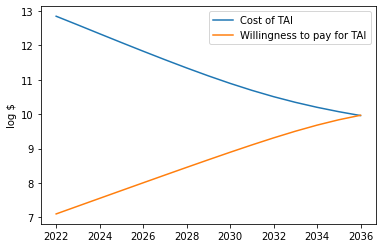

2037: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 3 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.3 log FLOP
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 3.9
-- Assume a scaling exponent of 0.529
-- Assume FLOPs per param per sec of 1.5
-- 32.0 = 13.3 + 1.6 + 0.1 + 3.9 + 12 - 0.529 * 11.2 + 0.529 * (13.3 + 1.6 - 1.5)
-- 32.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 32.0 log FLOPs (~103 nonillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.2 log 2022$USD (~157 million) and this increases by 3.4x per year to a max of 0.00107% of GDP. GDP gr

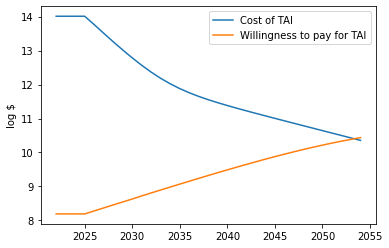

2055: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 4 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.1 log FLOP
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes 1.2 log FLOP compared to human
-- Assume a horizon length of 5.0
-- Assume a scaling exponent of 1.186
-- Assume FLOPs per param per sec of 1.2
-- 38.6 = 14.1 + 2.0 + 1.2 + 5.0 + 12 - 1.186 * 11.2 + 1.186 * (14.1 + 2.0 - 1.2)
-- 38.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 38.6 log FLOPs (~405 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.7 log 2022$USD (~514 million) and this increases by 4.9x per year to a max of 0.00054% of GD

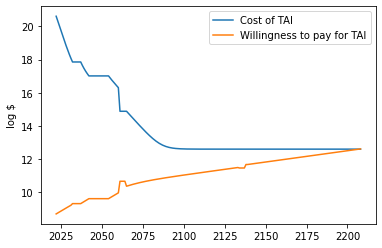

2209: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 5 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.1 log FLOP
-- Add 3.4 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 2.7
-- Assume a scaling exponent of 0.966
-- Assume FLOPs per param per sec of 1.5
-- 34.8 = 13.1 + 3.4 + -0.2 + 2.7 + 12 - 0.966 * 11.2 + 0.966 * (13.1 + 3.4 - 1.5)
-- 34.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 34.8 log FLOPs (~59 decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 4.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.2x per year to a max of 2e-05% of GDP. GDP grow

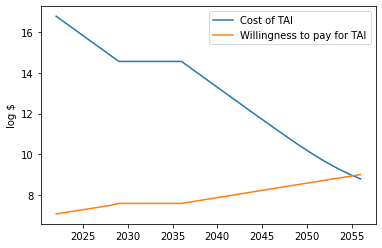

2057: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 6 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.2 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 9.6
-- Assume a scaling exponent of 0.931
-- Assume FLOPs per param per sec of 1.5
-- 43.3 = 17.2 + 0 + 0.3 + 9.6 + 12 - 0.931 * 11.2 + 0.931 * (17.2 + 0 - 1.5)
-- 43.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 43.3 log FLOPs (~22 billion decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.5x per year to a max of 1e-05% of GDP. GDP grows at a rate of 1.019x per year.
If a 

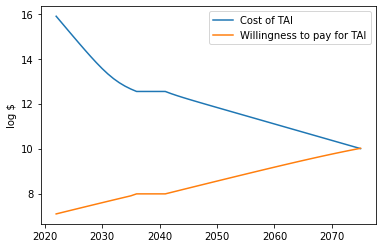

2076: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 9 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.8 log FLOP
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.782
-- Assume FLOPs per param per sec of 1.3
-- 28.4 = 13.8 + 1.4 + -0.9 + 0 + 12 - 0.782 * 11.2 + 0.782 * (13.8 + 1.4 - 1.3)
-- 28.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.4 log FLOPs (~26 octillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 1.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 2.7x per year to a max of 0.00139% of GDP. GDP grows at a rate of 1.024x per year.
If a no

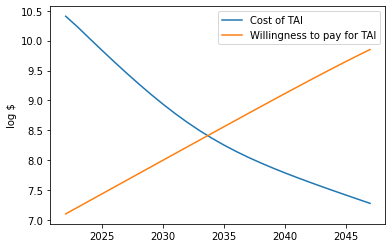

2048: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 10 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.6 log FLOP
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes -0.4 log FLOP compared to human
-- Assume a horizon length of 7.3
-- Assume a scaling exponent of 1.187
-- Assume FLOPs per param per sec of 1.6
-- 40.0 = 15.6 + 1.0 + -0.4 + 7.3 + 12 - 1.187 * 11.2 + 1.187 * (15.6 + 1.0 - 1.6)
-- 40.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 40.0 log FLOPs (~9 million decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.6x per year to a max of 2e-05% of GDP. 

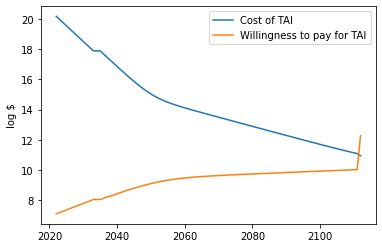

2113: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 13 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.0 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 4.6
-- Assume a scaling exponent of 1.147
-- Assume FLOPs per param per sec of 1.3
-- 30.0 = 13.0 + 0 + -0.2 + 4.6 + 12 - 1.147 * 11.2 + 1.147 * (13.0 + 0 - 1.3)
-- 30.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 30.0 log FLOPs (~972 octillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.8x per year to a max of 2e-05% of GDP. GDP grows at a

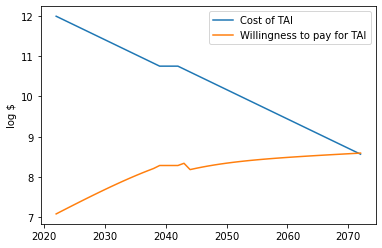

2073: ...Tool TAI made
2153: WAR!!! (Other)
2164: War ends :)
...Boring future
-
-
-
-
############
## RUN 14 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.3 log FLOP
-- Add 4.3 log FLOP for efficiency
-- Assume a transformative model takes -1.2 log FLOP compared to human
-- Assume a horizon length of 5.0
-- Assume a scaling exponent of 1.447
-- Assume FLOPs per param per sec of 1.2
-- 45.7 = 15.3 + 4.3 + -1.2 + 5.0 + 12 - 1.447 * 11.2 + 1.447 * (15.3 + 4.3 - 1.2)
-- 45.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 45.7 log FLOPs (~5 trillion decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 4.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.3x per year to a max of 0.00082% of GDP.

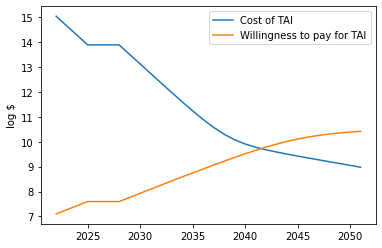

2052: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 17 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.0 log FLOP
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes -0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.606
-- Assume FLOPs per param per sec of 1.1
-- 33.5 = 17.0 + 1.4 + -0.5 + 0 + 12 - 0.606 * 11.2 + 0.606 * (17.0 + 1.4 - 1.1)
-- 33.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 33.5 log FLOPs (~3 decillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 1.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 6.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.5x per year to a max of 0.00089% of GDP. GDP grows 

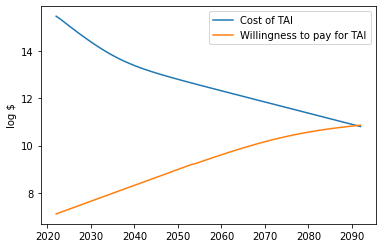

2093: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 18 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.8 log FLOP
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 2.2
-- Assume a scaling exponent of 1.855
-- Assume FLOPs per param per sec of 2.0
-- 34.4 = 14.8 + 1.0 + -0.6 + 2.2 + 12 - 1.855 * 11.2 + 1.855 * (14.8 + 1.0 - 2.0)
-- 34.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 34.4 log FLOPs (~23 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 1.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.8 log 2022$USD (~592 million) and this increases by 1x per year to a max of 0.00076% of GDP. GDP

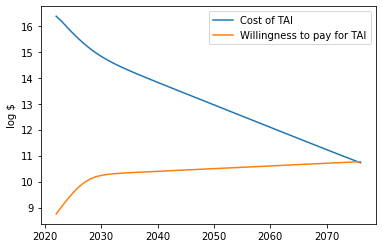

2077: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 19 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.7 log FLOP
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -2.1 log FLOP compared to human
-- Assume a horizon length of 0.3
-- Assume a scaling exponent of 0.886
-- Assume FLOPs per param per sec of 1.3
-- 28.1 = 13.7 + 1.7 + -2.1 + 0.3 + 12 - 0.886 * 11.2 + 0.886 * (13.7 + 1.7 - 1.3)
-- 28.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.1 log FLOPs (~12 octillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.6 log 2022$USD (~389 million) and this increases by 3.1x per year to a max of 0.00107% of GDP. GDP 

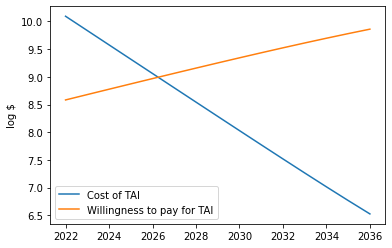

2037: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 20 ##
############
Anchor debug:
-- Assume human brain in inference takes 20.4 log FLOP
-- Add 2.3 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 4.7
-- Assume a scaling exponent of 0.859
-- Assume FLOPs per param per sec of 2.1
-- 47.3 = 20.4 + 2.3 + -0.1 + 4.7 + 12 - 0.859 * 11.2 + 0.859 * (20.4 + 2.3 - 2.1)
-- 47.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 47.3 log FLOPs (~202 trillion decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.9x per year to a max of 0.00063% of GDP. GDP grows at a rate 

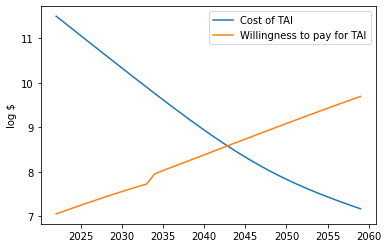

2060: ...Tool TAI made
2147: WAR!!! (Other)
2150: ...catastrophe from pathogen (war)
2152: War ends :)
2154: WAR!!! (US vs. China)
2158: War ends :)
2218: WAR!!! (US vs. Russia)
...Boring future
-
-
-
-
############
## RUN 22 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.1 log FLOP
-- Add 4.0 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 7.0
-- Assume a scaling exponent of 1.14
-- Assume FLOPs per param per sec of 2.1
-- 51.6 = 19.1 + 4.0 + -1.8 + 7.0 + 12 - 1.14 * 11.2 + 1.14 * (19.1 + 4.0 - 2.1)
-- 51.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 51.6 log FLOPs (~4 quintillion decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 5.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
W

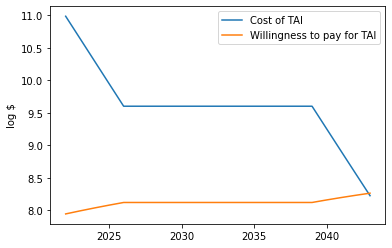

2044: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 24 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.2 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes 0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.351
-- Assume FLOPs per param per sec of 1.5
-- 33.5 = 16.2 + 0 + 0.7 + 0 + 12 - 1.351 * 11.2 + 1.351 * (16.2 + 0 - 1.5)
-- 33.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 33.5 log FLOPs (~3 decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 0.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.9x per year to a max of 0.00011% of GDP. GDP grows at a rat

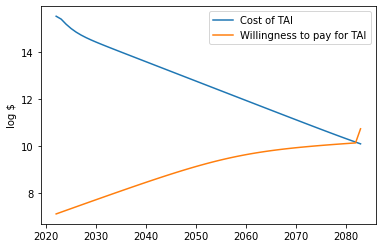

2084: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 25 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.2 log FLOP
-- Add 6.9 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 4.2
-- Assume a scaling exponent of 0.043
-- Assume FLOPs per param per sec of 1.0
-- 34.7 = 11.2 + 6.9 + 0.1 + 4.2 + 12 - 0.043 * 11.2 + 0.043 * (11.2 + 6.9 - 1.0)
-- 34.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 34.7 log FLOPs (~49 decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 8.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 5.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1x per year to a max of 0.00054% of GDP. GDP grows at a rate of 1.036x per year.
If a n

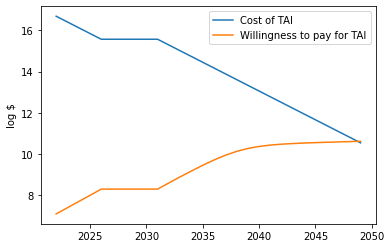

2050: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 26 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.3 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.018
-- Assume FLOPs per param per sec of 1.3
-- 39.1 = 18.3 + 1.5 + -0.3 + 0 + 12 - 1.018 * 11.2 + 1.018 * (18.3 + 1.5 - 1.3)
-- 39.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 39.1 log FLOPs (~1 million decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 1.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 6.2x per year to a max of 3e-05% of GDP. GDP 

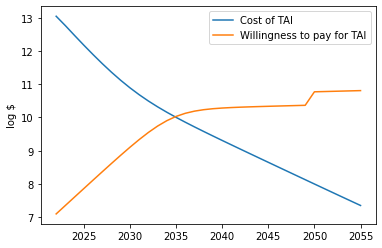

2056: ...XRISK from fully unaligned TAI (singleton) :(
-
-
-
-
############
## RUN 29 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.3 log FLOP
-- Add 2.2 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 4.3
-- Assume a scaling exponent of 1.117
-- Assume FLOPs per param per sec of 1.0
-- 35.8 = 14.3 + 2.2 + -1.8 + 4.3 + 12 - 1.117 * 11.2 + 1.117 * (14.3 + 2.2 - 1.0)
-- 35.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 35.8 log FLOPs (~577 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.3x per year to a max of 0.00386% of GDP. GDP grows at a rate of 1.028x 

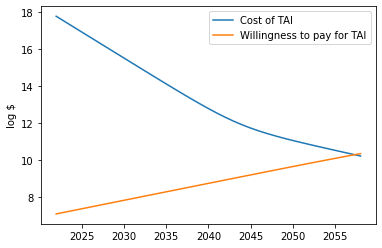

2059: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 30 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.0 log FLOP
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 9.3
-- Assume a scaling exponent of 1.77
-- Assume FLOPs per param per sec of 1.5
-- 45.0 = 15.0 + 1.8 + -0.6 + 9.3 + 12 - 1.77 * 11.2 + 1.77 * (15.0 + 1.8 - 1.5)
-- 45.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 45.0 log FLOPs (~940 billion decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.5x per year to a max of 0.00094% of GDP.

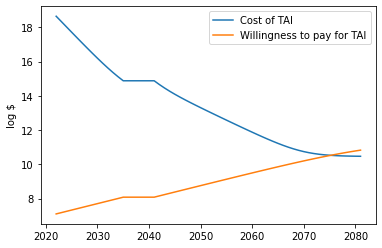

2082: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 32 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.0 log FLOP
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes 0.7 log FLOP compared to human
-- Assume a horizon length of 5.8
-- Assume a scaling exponent of 1.543
-- Assume FLOPs per param per sec of 2.2
-- 46.1 = 17.0 + 2.0 + 0.7 + 5.8 + 12 - 1.543 * 11.2 + 1.543 * (17.0 + 2.0 - 2.2)
-- 46.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 46.1 log FLOPs (~14 trillion decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.0x per year to a max of 0.00055% of 

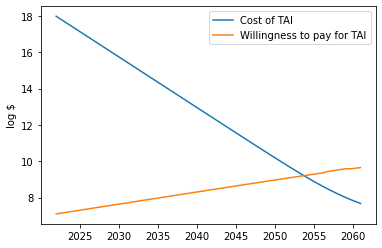

2062: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 34 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.7 log FLOP
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes 0.5 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.236
-- Assume FLOPs per param per sec of 1.3
-- 28.3 = 12.7 + 1.4 + 0.5 + 0 + 12 - 1.236 * 11.2 + 1.236 * (12.7 + 1.4 - 1.3)
-- 28.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.3 log FLOPs (~22 octillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.4x per year to a max of 0.00371% of GDP. GDP grows a

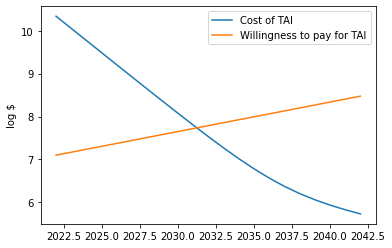

2043: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 35 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.1 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.3 log FLOP compared to human
-- Assume a horizon length of 4.2
-- Assume a scaling exponent of 0.935
-- Assume FLOPs per param per sec of 1.2
-- 27.7 = 12.1 + 0 + -0.3 + 4.2 + 12 - 0.935 * 11.2 + 0.935 * (12.1 + 0 - 1.2)
-- 27.7 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 27.7 log FLOPs (~6 octillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 2.7x per year to a max of 0.0009% of GDP. GDP grows at a 

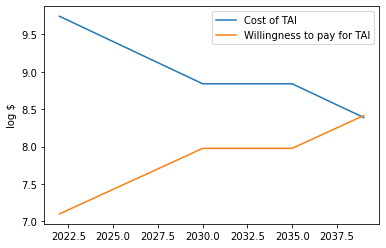

2040: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 36 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.1 log FLOP
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes 0.5 log FLOP compared to human
-- Assume a horizon length of 9.5
-- Assume a scaling exponent of 0.873
-- Assume FLOPs per param per sec of 1.4
-- 41.5 = 14.1 + 2.1 + 0.5 + 9.5 + 12 - 0.873 * 11.2 + 0.873 * (14.1 + 2.1 - 1.4)
-- 41.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 41.5 log FLOPs (~284 million decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 2.0x per year to a max of 0.00086% of 

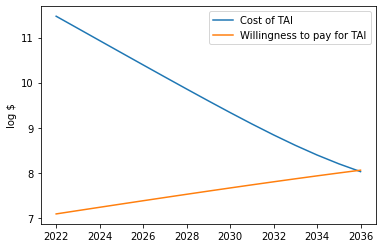

2037: ...Tool TAI made
2042: WAR!!! (Other)
2070: War ends :)
2134: WAR!!! (US vs. Russia)
2141: War ends :)
2197: WAR!!! (US vs. China)
2207: War ends :)
...Boring future
-
-
-
-
############
## RUN 39 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.6 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.879
-- Assume FLOPs per param per sec of 1.4
-- 30.9 = 14.6 + 1.5 + -0.2 + 0 + 12 - 0.879 * 11.2 + 0.879 * (14.6 + 1.5 - 1.4)
-- 30.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 30.9 log FLOPs (~7 nonillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 1.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$US

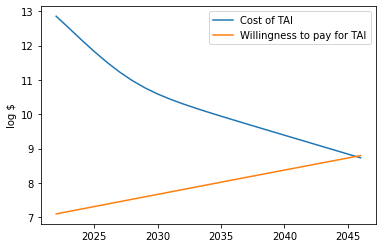

2047: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 40 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.3 log FLOP
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.939
-- Assume FLOPs per param per sec of 1.5
-- 38.0 = 18.3 + 2.0 + -1.3 + 0 + 12 - 0.939 * 11.2 + 0.939 * (18.3 + 2.0 - 1.5)
-- 38.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 38.0 log FLOPs (~106 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~87 million) and this increases by 1.8x per year to a max of 0.0006% of GD

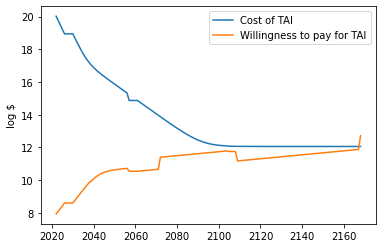

2169: ...Achieved aligned TAI (aligned by default), happy future! :D
-
-
-
-
############
## RUN 41 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.7 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -2.4 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.546
-- Assume FLOPs per param per sec of 1.5
-- 27.6 = 14.7 + 0 + -2.4 + 0 + 12 - 1.546 * 11.2 + 1.546 * (14.7 + 0 - 1.5)
-- 27.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 27.6 log FLOPs (~4 octillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.3x per year to a max of 0.00119% of GDP. GDP grows at a rate of 1.03x p

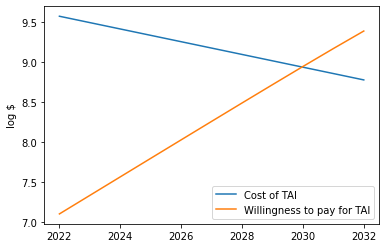

2033: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 42 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.9 log FLOP
-- Add 4.0 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.683
-- Assume FLOPs per param per sec of 2.1
-- 36.6 = 16.9 + 4.0 + -1.4 + 0 + 12 - 0.683 * 11.2 + 0.683 * (16.9 + 4.0 - 2.1)
-- 36.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 36.6 log FLOPs (~4 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 4.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.6x per year to a max of 0.00074% of GDP. GDP grows at a rate of 1.0

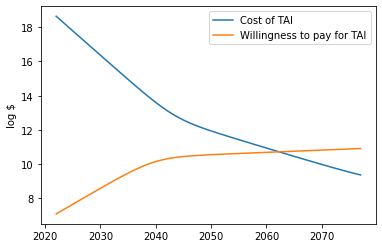

2078: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 43 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.2 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.2 log FLOP compared to human
-- Assume a horizon length of 5.6
-- Assume a scaling exponent of 0.627
-- Assume FLOPs per param per sec of 1.3
-- 40.8 = 19.2 + 0 + -0.2 + 5.6 + 12 - 0.627 * 11.2 + 0.627 * (19.2 + 0 - 1.3)
-- 40.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 40.8 log FLOPs (~68 million decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 0.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.6x per year to a max of 0.00059% of GDP. GDP grows at a rate of 1.015x per year.


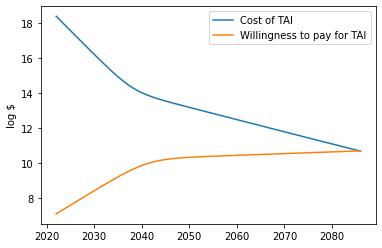

2087: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 45 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.6 log FLOP
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.687
-- Assume FLOPs per param per sec of 1.5
-- 33.5 = 17.6 + 1.3 + -1.8 + 0 + 12 - 0.687 * 11.2 + 0.687 * (17.6 + 1.3 - 1.5)
-- 33.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 33.5 log FLOPs (~3 decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 1.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.7x per year to a max of 1e-05% of GDP. GDP grows at

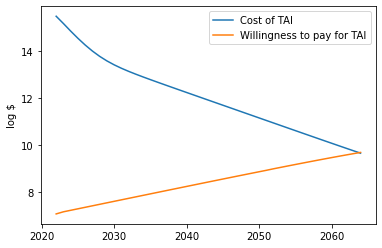

2065: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 46 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.0 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.03
-- Assume FLOPs per param per sec of 1.6
-- 25.4 = 14.0 + 0 + -1.8 + 0 + 12 - 1.03 * 11.2 + 1.03 * (14.0 + 0 - 1.6)
-- 25.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 25.4 log FLOPs (~27 septillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 1.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.4x per year to a max of 0.00224% of GDP. GDP grows at a ra

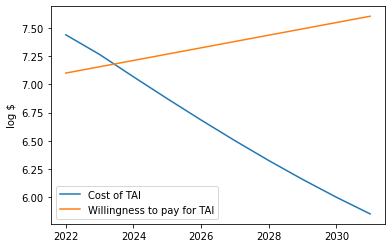

2032: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 47 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.1 log FLOP
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 3.4
-- Assume a scaling exponent of 0.83
-- Assume FLOPs per param per sec of 1.8
-- 31.9 = 13.1 + 1.8 + 0.1 + 3.4 + 12 - 0.83 * 11.2 + 0.83 * (13.1 + 1.8 - 1.8)
-- 31.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 31.9 log FLOPs (~77 nonillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.2 log 2022$USD (~148 million) and this increases by 3.7x per year to a max of 0.00054% of GDP. GDP grows

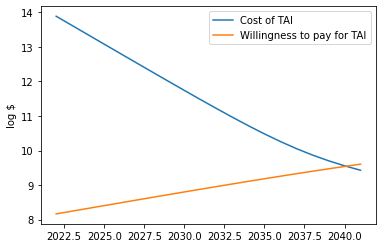

2042: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 48 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.7 log FLOP
-- Add 3.5 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 9.2
-- Assume a scaling exponent of 0.72
-- Assume FLOPs per param per sec of 1.1
-- 42.3 = 13.7 + 3.5 + 0.3 + 9.2 + 12 - 0.72 * 11.2 + 0.72 * (13.7 + 3.5 - 1.1)
-- 42.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 42.3 log FLOPs (~2 billion decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 4.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.2 log 2022$USD (~154 million) and this increases by 4.3x per year to a max of 2e-05% of GDP. GDP 

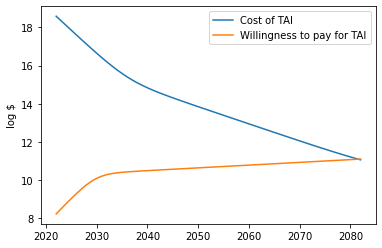

2083: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 50 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.8 log FLOP
-- Add 1.8 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 2.1
-- Assume a scaling exponent of 0.606
-- Assume FLOPs per param per sec of 1.6
-- 37.0 = 17.8 + 1.8 + -0.9 + 2.1 + 12 - 0.606 * 11.2 + 0.606 * (17.8 + 1.8 - 1.6)
-- 37.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 37.0 log FLOPs (~11 thousand decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 6.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~71 million) and this increases by 1.2x per year to a max of 3e-05% of GDP

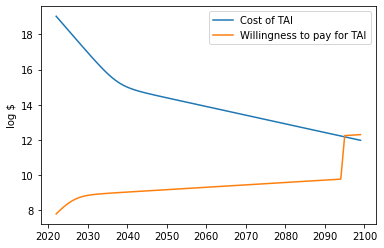

2100: ...Tool TAI made
2111: War ends :)
...Boring future
-
-


In [17]:
for i in range(50):
    print('-')
    print('-')
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbose=True)

In [18]:
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            raw=True, verbose=True, n=RUNS)

Checking cache...
Generating Bayes net...


100%|█████████████████████████████████████████████████████████████| 5000/5000 [01:34<00:00, 53.14it/s]

...Generated
Caching...
...Cached


In [19]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('0. World State At Year')
for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

0. World State At Year
## 2030 ##
[('boring', 96.98),
 ('xrisk_full_unaligned_tai_singleton', 1.06),
 ('aligned_tai', 0.64),
 ('xrisk_full_unaligned_tai_extinction', 0.6),
 ('xrisk_subtly_unaligned_tai', 0.32),
 ('xrisk_tai_misuse', 0.28),
 ('xrisk_nukes_war', 0.08),
 ('xrisk_nukes_accident', 0.02),
 ('xrisk_bio_accident', 0.02),
 ('xrisk_unknown_unknown', 0.0),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 74.56),
 ('aligned_tai', 13.64),
 ('xrisk_full_unaligned_tai_singleton', 4.62),
 ('xrisk_full_unaligned_tai_extinction', 3.14),
 ('xrisk_subtly_unaligned_tai', 2.46),
 ('xrisk_tai_misuse', 1.24),
 ('xrisk_nukes_war', 0.24),
 ('xrisk_nukes_accident', 0.06),
 ('xrisk_bio_accident', 0.02),
 ('xrisk_bio_nonstate', 0.02),
 ('xrisk_unknown_unknown', 0.0),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2070 ##
[('boring', 57.46),
 ('aligned_tai', 25.5),
 ('xr

In [20]:
print('0B. Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')
    
# TODO: Small chance that war produces non-nukes catastrophe
# TODO: Chance of getting nukes-based singleton via secure first strike

0B. Catastrophe States At Year
## 2023 ##
[('', 99.34),
 ('nukes_war', 0.24),
 ('natural_pathogen', 0.16),
 ('engineered_pathogen', 0.12),
 ('xrisk_full_unaligned_tai_singleton', 0.1)]
-
-
## 2030 ##
[('', 95.36),
 ('nukes_war', 1.22),
 ('xrisk_full_unaligned_tai_singleton', 0.8),
 ('engineered_pathogen', 0.7),
 ('xrisk_full_unaligned_tai_extinction', 0.6),
 ('natural_pathogen', 0.5),
 ('nukes_accident', 0.38),
 ('xrisk_tai_misuse', 0.22)]
-
-
## 2050 ##
[('', 84.5),
 ('xrisk_full_unaligned_tai_singleton', 3.36),
 ('xrisk_full_unaligned_tai_extinction', 3.1),
 ('nukes_war', 2.82),
 ('engineered_pathogen', 1.64),
 ('nukes_accident', 1.24),
 ('natural_pathogen', 1.18),
 ('xrisk_tai_misuse', 0.9),
 ('averting_misaligned_tai', 0.42),
 ('nukes_war nukes_war', 0.12),
 ('engineered_pathogen nukes_war', 0.12),
 ('supervolcano', 0.12),
 ('nukes_accident nukes_war', 0.1)]
-
-
## 2070 ##
[('', 79.98),
 ('xrisk_full_unaligned_tai_singleton', 4.42),
 ('xrisk_full_unaligned_tai_extinction', 3.96),
 

In [21]:
print('0C. *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')
    
# TODO: Print world state with x-risk or catastrophe

0C. *First* Catastrophe State At Year
## 2023 ##
[('', 99.34),
 ('nukes_war', 0.24),
 ('natural_pathogen', 0.16),
 ('engineered_pathogen', 0.12),
 ('xrisk_full_unaligned_tai_singleton', 0.1)]
-
-
## 2030 ##
[('', 95.36),
 ('nukes_war', 1.26),
 ('xrisk_full_unaligned_tai_singleton', 0.8),
 ('engineered_pathogen', 0.74),
 ('xrisk_full_unaligned_tai_extinction', 0.6),
 ('natural_pathogen', 0.5),
 ('nukes_accident', 0.38),
 ('xrisk_tai_misuse', 0.22)]
-
-
## 2050 ##
[('', 84.5),
 ('xrisk_full_unaligned_tai_singleton', 3.36),
 ('nukes_war', 3.14),
 ('xrisk_full_unaligned_tai_extinction', 3.1),
 ('engineered_pathogen', 1.82),
 ('nukes_accident', 1.34),
 ('natural_pathogen', 1.26),
 ('xrisk_tai_misuse', 0.9),
 ('averting_misaligned_tai', 0.42),
 ('supervolcano', 0.14)]
-
-
## 2070 ##
[('', 79.98),
 ('xrisk_full_unaligned_tai_singleton', 4.42),
 ('nukes_war', 4.06),
 ('xrisk_full_unaligned_tai_extinction', 3.96),
 ('engineered_pathogen', 2.44),
 ('nukes_accident', 1.68),
 ('natural_pathogen', 

In [22]:
print('0D. Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

0D. Double Catastrophe X-Risks
## 2030 ##
[('', 100.0)]
-
-
## 2050 ##
[('', 100.0)]
-
-
## 2070 ##
[('', 100.0)]
-
-
## 2100 ##
[('', 99.98), ('engineered_pathogen->engineered_pathogen', 0.02)]
-
-
## 2200 ##
[('', 99.94),
 ('engineered_pathogen->engineered_pathogen', 0.02),
 ('nukes_war->nukes_war', 0.02),
 ('nukes_war->nukes_accident', 0.02)]
-
-


In [23]:
print('0E. # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

0E. # of Catastrophes At Year
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 1.0}
-
-
## # of catastrophes as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-


In [24]:
print('0F. War States At Year')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 2)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

0F. War States At Year
## 2030 ##
[('', 71.58),
 ('US/China', 18.32),
 ('US/Russia', 9.14),
 ('Other', 0.88),
 ('US/China US/Russia', 0.04),
 ('US/China US/China', 0.02),
 ('US/Russia US/Russia', 0.02)]
-
-
## 2050 ##
[('', 49.46),
 ('US/China', 33.4),
 ('US/Russia', 13.02),
 ('Other', 3.16),
 ('US/China US/Russia', 0.32),
 ('US/China US/China', 0.26),
 ('Other US/China', 0.22),
 ('US/Russia US/Russia', 0.1),
 ('Other US/Russia', 0.06)]
-
-
## 2070 ##
[('', 42.02),
 ('US/China', 34.48),
 ('US/Russia', 14.22),
 ('Other', 5.82),
 ('US/China US/Russia', 1.06),
 ('US/China US/China', 0.84),
 ('Other US/China', 0.72),
 ('Other US/Russia', 0.38),
 ('US/Russia US/Russia', 0.3),
 ('Other Other', 0.08),
 ('Other Other US/Russia', 0.02),
 ('Other US/China US/China', 0.02),
 ('US/China US/China US/China', 0.02),
 ('Other US/China US/Russia', 0.02)]
-
-
## 2100 ##
[('', 35.88),
 ('US/China', 32.78),
 ('US/Russia', 14.36),
 ('Other', 7.42),
 ('US/China US/Russia', 2.66),
 ('US/China US/China', 2.28

In [25]:
print('0G. War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - CURRENT_YEAR) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

0G. War Length States At Year
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 25.0,
 90: 62.5,
 95: 75.0,
 99: 100.0}
-
-
## Percent of time in war as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 14.3,
 70: 25.0,
 80: 39.3,
 90: 60.7,
 95: 78.6,
 99: 96.4}
-
-
## Percent of time in war as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 6.2,
 60: 12.5,
 70: 18.8,
 80: 31.2,
 90: 47.9,
 95: 68.8,
 99: 91.7}
-
-
## Percent of time in war as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 2.6,
 50: 6.4,
 60: 10.3,
 70: 15.4,
 80: 23.1,
 90: 37.2,
 95: 51.3,
 99: 85.9}
-
-
## Percent of time in war as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.6,
 40: 2.8,
 50: 5.1,
 60: 7.9,
 70: 11.2,
 80: 15.7,
 90: 24.2,
 95: 32.0,
 99: 54.5}
-
-


In [26]:
print('0H. # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')

0H. # of Wars At Year
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-
## # of wars as of 2200 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 2.0,
 90: 2.0,
 95: 3.0,
 99: 4.0}
-
-


In [27]:
print('1. Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['engineered_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

1. Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 1.82%
2050 - 5.54%
2100 - 10.56%


In [28]:
print('2. Non-Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['natural_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))    

2. Non-Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 1.46%
2050 - 3.62%
2100 - 6.6%


In [29]:
print('2B. Pathogen Catastrophic Risk (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'pathogen' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

# TODO: Percentages for different sources of pathogen


2B. Pathogen Catastrophic Risk (10%+ death)
2030 - 1.26%
2050 - 3.16%
2100 - 5.42%


In [30]:
print('2C. Pathogen Extinction Risk')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk_bio' in e['collectors'][y_c]['category'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))

# TODO: Percentages for different sources of pathogen
    

2C. Pathogen Extinction Risk
2030 - 0.02%
2050 - 0.04%
2100 - 0.08%


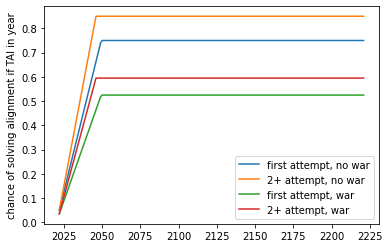

In [31]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()
# TODO: Make logistic?


In [32]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment with no war 5.0% (2nd attempt 5.0%)
Year: 2023 - chance of solving TAI alignment with no war 8.0% (2nd attempt 8.0%)
Year: 2024 - chance of solving TAI alignment with no war 10.0% (2nd attempt 12.0%)
Year: 2025 - chance of solving TAI alignment with no war 13.0% (2nd attempt 15.0%)
Year: 2026 - chance of solving TAI alignment with no war 15.0% (2nd attempt 18.0%)
Year: 2027 - chance of solving TAI alignment with no war 18.0% (2nd attempt 22.0%)
Year: 2028 - chance of solving TAI alignment with no war 20.0% (2nd attempt 25.0%)
Year: 2029 - chance of solving TAI alignment with no war 23.0% (2nd attempt 28.0%)
Year: 2030 - chance of solving TAI alignment with no war 25.0% (2nd attempt 32.0%)
Year: 2031 - chance of solving TAI alignment with no war 28.0% (2nd attempt 35.0%)
Year: 2032 - chance of solving TAI alignment with no war 31.0% (2nd attempt 38.0%)
Year: 2033 - chance of solving TAI alignment with no war 33.0% (2nd attempt 42.0%)
Year: 20

In [33]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0)))


Year: 2022 - chance of solving TAI alignment with war 3.0% (2nd attempt 3.0%)
Year: 2023 - chance of solving TAI alignment with war 5.0% (2nd attempt 6.0%)
Year: 2024 - chance of solving TAI alignment with war 7.0% (2nd attempt 8.0%)
Year: 2025 - chance of solving TAI alignment with war 9.0% (2nd attempt 11.0%)
Year: 2026 - chance of solving TAI alignment with war 11.0% (2nd attempt 13.0%)
Year: 2027 - chance of solving TAI alignment with war 12.0% (2nd attempt 15.0%)
Year: 2028 - chance of solving TAI alignment with war 14.0% (2nd attempt 18.0%)
Year: 2029 - chance of solving TAI alignment with war 16.0% (2nd attempt 20.0%)
Year: 2030 - chance of solving TAI alignment with war 18.0% (2nd attempt 22.0%)
Year: 2031 - chance of solving TAI alignment with war 20.0% (2nd attempt 24.0%)
Year: 2032 - chance of solving TAI alignment with war 21.0% (2nd attempt 27.0%)
Year: 2033 - chance of solving TAI alignment with war 23.0% (2nd attempt 29.0%)
Year: 2034 - chance of solving TAI alignment wi

In [34]:
print('3. AI Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'tai' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

3. AI Catastrophic Risk* (10%+ death)
2030 - 1.74%
2050 - 7.98%
2100 - 12.56%


In [35]:
print('4. AI Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_full_unaligned_tai_extinction',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


4. AI Extinction Risk*
2030 - 0.6%
2050 - 3.14%
2100 - 4.78%


In [36]:
print('4B. AI X-Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4B. AI X-Risk
2024 - 0.2% (Extinction: 0.0%, Bad TAI singleton: 0.1%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.0%)
2030 - 2.3% (Extinction: 0.6%, Bad TAI singleton: 1.1%, Subtly misaligned singleton: 0.3%, Misuse singleton: 0.3%)
2050 - 11.5% (Extinction: 3.1%, Bad TAI singleton: 4.6%, Subtly misaligned singleton: 2.5%, Misuse singleton: 1.2%)
2070 - 16.5% (Extinction: 4.1%, Bad TAI singleton: 6.1%, Subtly misaligned singleton: 4.6%, Misuse singleton: 1.7%)
2100 - 20.2% (Extinction: 4.8%, Bad TAI singleton: 7.2%, Subtly misaligned singleton: 6.2%, Misuse singleton: 2.0%)
2200 - 22.6% (Extinction: 5.3%, Bad TAI singleton: 8.0%, Subtly misaligned singleton: 6.9%, Misuse singleton: 2.4%)


In [37]:
# “P(misalignment x-risk|AGI)”: Conditional on AGI being developed by 2070, humanity will go extinct or
# drastically curtail its future potential due to loss of control of AGI

print('4C. AI X-Risk conditional on AGI by 2070')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          conditional_on=lambda e: e['final_state']['tai_year'] <= 2070 if e['final_state']['tai_year'] is not None else False,
                          n=RUNS)

for y_c in [2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4C. AI X-Risk conditional on AGI by 2070
2070 - 33.8% (Extinction: 8.4%, Bad TAI singleton: 12.6%, Subtly misaligned singleton: 9.4%, Misuse singleton: 3.4%)
2100 - 34.1% (Extinction: 8.5%, Bad TAI singleton: 12.7%, Subtly misaligned singleton: 9.5%, Misuse singleton: 3.4%)


In [38]:
print('4D. Aligned TAI')
for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

4D. Aligned TAI
2024 - 0.0%
2030 - 0.64%
2050 - 13.64%
2070 - 25.5%
2100 - 33.74%
2200 - 39.32%


In [39]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
pprint(sq.get_percentiles([2223 if yr is None else yr for yr in yrs]))
print('-')

def bin_tai_yrs(low=None, hi=None):
    low = CURRENT_YEAR if low is None else low
    if hi is None:
        r = bayes.bayesnet(define_event,
                           find=lambda e: e['final_state']['tai_year'] is None or e['final_state']['tai_year'] >= low,
                           n=RUNS)
    else:
        r = bayes.bayesnet(define_event,
                           find=lambda e: (e['final_state']['tai_year'] is not None and
                                          (e['final_state']['tai_year'] >= low and e['final_state']['tai_year'] <= hi)),
                           n=RUNS)
    return round(r * 100, 1)

print('<2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('2025-2029: {}%'.format(bin_tai_yrs(2025, 2029)))
print('2030-2039: {}%'.format(bin_tai_yrs(2030, 2039)))
print('2040-2049: {}%'.format(bin_tai_yrs(2040, 2049)))
print('2050-2059: {}%'.format(bin_tai_yrs(2050, 2059)))
print('2060-2069: {}%'.format(bin_tai_yrs(2060, 2069)))
print('2070-2079: {}%'.format(bin_tai_yrs(2070, 2079)))
print('2080-2089: {}%'.format(bin_tai_yrs(2080, 2089)))
print('2090-2099: {}%'.format(bin_tai_yrs(2090, 2099)))
print('2100-2149: {}%'.format(bin_tai_yrs(2100, 2149)))
print('2149-2199: {}%'.format(bin_tai_yrs(2149, 2199)))
print('>2200: {}%'.format(bin_tai_yrs(low=2220)))
print('-')

print('By EOY 2023: {}%'.format(bin_tai_yrs(hi=2023)))
print('By EOY 2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('By EOY 2025: {}%'.format(bin_tai_yrs(hi=2025)))
print('By EOY 2030: {}% (Ajeya 2022: 15%)'.format(bin_tai_yrs(hi=2030)))
print('By EOY 2032: {}% (within 10yrs)'.format(bin_tai_yrs(hi=2032)))
print('By EOY 2036: {}% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)'.format(bin_tai_yrs(hi=2036)))
print('By EOY 2040: {}% (Ajeya 2022: 50%)'.format(bin_tai_yrs(hi=2040)))
print('By EOY 2042: {}% (FTX: 20%, 10%-45%)'.format(bin_tai_yrs(hi=2042)))
print('By EOY 2047: {}% (within 25yrs)'.format(bin_tai_yrs(hi=2047)))
print('By EOY 2050: {}% (Ajeya 2020: 50%, Ajeya 2022: 60%)'.format(bin_tai_yrs(hi=2050)))
print('By EOY 2060: {}% (Holden benchmark - 25%-75%, Holden: 50%)'.format(bin_tai_yrs(hi=2060)))
print('By EOY 2070: {}% (Carlsmith: 50%)'.format(bin_tai_yrs(hi=2070)))
print('By EOY 2072: {}% (within 50yrs)'.format(bin_tai_yrs(hi=2072)))
print('By EOY 2078: {}% (within my expected lifetime)'.format(bin_tai_yrs(hi=2078)))
print('By EOY 2099: {}% (FTX: 60%, >30%)'.format(bin_tai_yrs(hi=2099)))
print('By EOY 2100: {}% (Holden benchmark - 33%-90%, Holden: 66%)'.format(bin_tai_yrs(hi=2100)))
print('By EOY 2122: {}% (within 100yrs)'.format(bin_tai_yrs(hi=2122)))
print('By EOY 2222: {}% (within 200yrs)'.format(bin_tai_yrs(hi=2222)))


4E. When TAI?
-
{1: 2026.0,
 5: 2031.0,
 10: 2036.0,
 20: 2043.0,
 30: 2051.0,
 40: 2060.0,
 50: 2072.0,
 60: 2093.0,
 70: 2184.2999999999997,
 80: 2223.0,
 90: 2223.0,
 95: 2223.0,
 99: 2223.0}
-
<2024: 0.4%
2025-2029: 2.9%
2030-2039: 11.9%
2040-2049: 13.5%
2050-2059: 10.8%
2060-2069: 8.3%
2070-2079: 6.3%
2080-2089: 4.6%
2090-2099: 2.7%
2100-2149: 6.1%
2149-2199: 3.4%
>2200: 28.1%
-
By EOY 2023: 0.2%
By EOY 2024: 0.4%
By EOY 2025: 0.7%
By EOY 2030: 4.2% (Ajeya 2022: 15%)
By EOY 2032: 6.1% (within 10yrs)
By EOY 2036: 10.8% (Holden benchmark - 10%-50%, Holden: 10%; Ajeya 2022: 35%)
By EOY 2040: 16.6% (Ajeya 2022: 50%)
By EOY 2042: 19.5% (FTX: 20%, 10%-45%)
By EOY 2047: 26.6% (within 25yrs)
By EOY 2050: 29.9% (Ajeya 2020: 50%, Ajeya 2022: 60%)
By EOY 2060: 40.4% (Holden benchmark - 25%-75%, Holden: 50%)
By EOY 2070: 48.7% (Carlsmith: 50%)
By EOY 2072: 50.3% (within 50yrs)
By EOY 2078: 53.8% (within my expected lifetime)
By EOY 2099: 61.5% (FTX: 60%, >30%)
By EOY 2100: 61.7% (Holden bench

In [40]:
print('5. Nuclear Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'nukes' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

5. Nuclear Catastrophic Risk* (10%+ death)
2030 - 1.66%
2050 - 4.66%
2100 - 7.6%


In [41]:
print('6. Nuclear Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    war = find(y_c, 'xrisk_nukes_war')
    accident = find(y_c, 'xrisk_nukes_accident')
    print('{} - {}% (war: {}%, accident: {}%)'.format(y_c,
                                                      round((war + accident) * 100, 3),
                                                      round(war * 100, 3),
                                                      round(accident * 100, 3)))
    

6. Nuclear Extinction Risk*
2030 - 0.1% (war: 0.08%, accident: 0.02%)
2050 - 0.3% (war: 0.24%, accident: 0.06%)
2100 - 0.64% (war: 0.46%, accident: 0.18%)
2200 - 1.04% (war: 0.66%, accident: 0.38%)


In [42]:
print('7. Non-Anthropogenic Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'supervolcano' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    
# NOTE: All other sources < 0.01%


7. Non-Anthropogenic Catastrophic Risk* (10%+ death)
2030 - 0.06%
2050 - 0.14%
2100 - 0.26%


In [43]:
print('8. Non-Anthropogenic Extinction Risk*')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_supervolcano',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 4)))

# NOTE: All other sources < 0.01%


8. Non-Anthropogenic Extinction Risk*
2030 - 0.0%
2050 - 0.0%
2100 - 0.0%


In [44]:
print('9. Total Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

9. Total Catastrophic Risk* (10%+ death)
2030 - 4.64%
2050 - 15.5%
2100 - 24.18%


In [45]:
print('10. Total Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

10. Total Extinction Risk*
2030 - 0.72% (AI: 0.6%, Nukes: 0.1% (War: 0.08% Accident: 0.02%), Bio: 0.02% (War: 0.0%, Accident: 0.02%, Nonstate: 0.0%), Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2050 - 3.48% (AI: 3.14%, Nukes: 0.3% (War: 0.24% Accident: 0.06%), Bio: 0.04% (War: 0.0%, Accident: 0.02%, Nonstate: 0.02%), Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2100 - 5.54% (AI: 4.78%, Nukes: 0.64% (War: 0.46% Accident: 0.18%), Bio: 0.08% (War: 0.0%, Accident: 0.04%, Nonstate: 0.04%), Nano: 0.0%, Natural: 0.0%, Other: 0.04%)
2200 - 6.78% (AI: 5.28%, Nukes: 1.04% (War: 0.66% Accident: 0.38%), Bio: 0.08% (War: 0.0%, Accident: 0.04%, Nonstate: 0.04%), Nano: 0.16%, Natural: 0.0%, Other: 0.22%)


In [46]:
print('10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2030, 2035, 2037, 2040, 2045, 2050, 2060, 2070, 2100, 2200]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))

# TODO: Non-AI singletons


10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)
2023 - 0.16% (AI: 0.14%, Nukes: 0.02%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.2% (AI: 0.16%, Nukes: 0.04%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2030 - 2.38% (AI: 2.26%, Nukes: 0.1%, Bio: 0.02%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2035 - 5.2% (AI: 4.98%, Nukes: 0.2%, Bio: 0.02%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2037 - 6.2% (AI: 5.98%, Nukes: 0.2%, Bio: 0.02%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2040 - 8.12% (AI: 7.88%, Nukes: 0.22%, Bio: 0.02%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2045 - 10.24% (AI: 9.98%, Nukes: 0.24%, Bio: 0.02%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2050 - 11.8% (AI: 11.46%, Nukes: 0.3%, Bio: 0.04%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2060 - 14.62% (AI: 14.08%, Nukes: 0.48%, Bio: 0.06%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2070 - 17.04% (AI: 16.48%, Nukes: 0.5%, Bio: 0.06%, Nano: 0.0%, Natural: 0.0%,

In [47]:
print('10C. Total X-Risk OR catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

# TODO: Non-AI singletons


10C. Total X-Risk OR catastrophe
2024 - 1.12%
2030 - 5.34%
2050 - 19.66%
2070 - 26.7%
2100 - 32.42%
2200 - 40.64%


In [48]:
print('10D. Total X-Risk AND catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

# TODO: Non-AI singletons


10D. Total X-Risk AND catastrophe
2024 - 0.12%
2030 - 1.68%
2050 - 7.64%
2070 - 10.36%
2100 - 12.68%
2200 - 14.8%


In [49]:
print('11. Year of Extinction*')
rs = bayes.bayesnet(define_event,
                    find=lambda e: (e['final_state']['category'], e['final_state']['final_year']),
                    raw=True,
                    n=RUNS)
extinction_years = [r[1] if r[0] in extinctions else 100000 for r in rs]
pprint(sq.get_percentiles(extinction_years, [5, 25, 50, 75, 95]))


11. Year of Extinction*
{5: 2078.95, 25: 100000.0, 50: 100000.0, 75: 100000.0, 95: 100000.0}


In [50]:
print('12. Future Human Births*')
pop_per_year = sq.lognorm(100*M, 1*B)
populations = [round((y - CURRENT_YEAR) * sq.sample(pop_per_year), 0) for y in extinction_years]
sq.get_log_percentiles(populations, [5, 25, 50, 75, 95])


12. Future Human Births*


{5: '10^10.3', 25: '10^13.2', 50: '10^13.5', 75: '10^13.7', 95: '10^14.0'}

In [51]:
print('13. Non-Coronavirus mRNA Vaccine*')

n_in_trials_2024 = sq.lognorm(36000, 36000*3)
n_in_scaled_vaccine = sq.lognorm(2*M, 2*B)
p_scaled_vaccine_by_2024 = 0.03

n_in_trials_2030 = sq.lognorm(108*K, 360*K)
p_scaled_vaccine_by_2030 = 0.1

p_aligned_tai_by_2024 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2024]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2024 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2024]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2024


def sim_2024():
    n = sq.sample(n_in_trials_2024)
    if sq.event_occurs(p_aligned_tai_by_2024):
        return n
    elif sq.event_occurs(p_xrisk_by_2024):
        return n / 3
    elif sq.event_occurs(p_scaled_vaccine_by_2024):
        return n + sq.sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?
    
    
p_aligned_tai_by_2030 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2030]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2030 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2030]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2030

def sim_2030(): # TODO: DRY
    n = sq.sample(n_in_trials_2030)
    if sq.event_occurs(p_aligned_tai_by_2030):
        return n
    elif sq.event_occurs(p_xrisk_by_2030):
        return n / 3
    elif sq.event_occurs(p_scaled_vaccine_by_2030):
        return n + sq.sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?


print('## 2024 ##')
pprint(sq.get_percentiles([sim_2024() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))

print('## 2030 ##')
pprint(sq.get_percentiles([sim_2030() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))


13. Non-Coronavirus mRNA Vaccine*
## 2024 ##
{5: 35833, 25: 49947, 50: 62881, 75: 79457, 95: 121011}
## 2030 ##
{5: 99185, 25: 154721, 50: 204259, 75: 277858, 95: 60052876}


In [52]:
print('31. Nuclear Weapon Use')
for y_c in [2024, 2030]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

31. Nuclear Weapon Use
2024 - 6.04%
2030 - 10.46%


In [53]:
print('53. GWP >15% by 2100?')
bayes.bayesnet(define_event,
               find=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                              (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               n=RUNS) * 0.7 * 0.9


53. GWP >15% by 2100?


0.21256199999999997

In [54]:
print('53. Year GWP >15% if by 2100')
bayes.bayesnet(define_event,
               find=lambda e: e['final_state']['final_year'],
               conditional_on=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                                         (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               reduce_fn=lambda y: sq.get_percentiles(y, [95, 75, 50, 25, 5]),
               n=RUNS)


53. Year GWP >15% if by 2100


{95: 2090.0, 75: 2070.0, 50: 2055.0, 25: 2044.0, 5: 2034.0}

In [55]:
print('55. Space Colony*')

def p_space_colony_if_boring(year):
    return 1 - (0.998 ** year)

p_space_colony_if_aligned_tai = 0.1

for y_c in [2030, 2050, 2100]:
    p_aligned_tai = bayes.bayesnet(define_event,
                                   find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                                   n=RUNS)
    p_boring = bayes.bayesnet(define_event,
                              find=lambda e: e['collectors'][y_c]['category'] == 'boring',
                              n=RUNS)
    
    print('{} - {} * {} + {} * {} = {}%'.format(y_c,
                                                round(p_boring, 3),
                                                round(p_space_colony_if_boring(y_c - CURRENT_YEAR), 3),
                                                round(p_aligned_tai, 3),
                                                p_space_colony_if_aligned_tai,
                                                round(((p_boring * p_space_colony_if_boring(y_c - CURRENT_YEAR)) +
                                                       (p_aligned_tai * p_space_colony_if_aligned_tai)) * 100, 2)))


55. Space Colony*
2030 - 0.97 * 0.016 + 0.006 * 0.1 = 1.6%
2050 - 0.746 * 0.055 + 0.136 * 0.1 = 5.43%
2100 - 0.453 * 0.145 + 0.337 * 0.1 = 9.93%
